In [1]:
import pandas as pd
import glob, os

import networkx as nx

from matplotlib.colors import Normalize
from matplotlib.colorbar import ColorbarBase
from matplotlib.patches import Circle

from seahorse import Graph, SContainer, venn_dic
from seahorse import constants, sns
constants.SHOWMODE = True

from collections import defaultdict

cpal = ["#90ee90", "#6495ed", "#ca472f", "#f6c85f", "#6f4e7c", "#ffa056", "#558254", "#4ad9e1"]

In [2]:
def add_labels(df, mapper) :
    df["label1"] = df["Var1"] + " (" + df["Var1_central_node"].map(mapper).astype(str) + ")"
    df["label2"] = df["Var2"] + " (" + df["Var2_central_node"].map(mapper).astype(str) + ")"
    return df

def iter_edges(df, cname1, cname2):
    for idx, row in df.iterrows() :
        yield (row[cname1], row[cname2], {"corr" : row["corr_coeff"]})

def neighborhood(G, node, n):
    path_lengths = nx.single_source_dijkstra_path_length(G, node)
    return [node for node, length in path_lengths.items()
                    if length <= n]

def make_graph(df, target, cname1, cname2, coef, expen, seed, cmap='Spectral') :

    sdf = df[(df["corr_coeff"] > coef) | (df["corr_coeff"] < -coef)]

    G = nx.Graph()
    G.add_edges_from(iter_edges(sdf,cname1, cname2))

    nodes = neighborhood(G, target, expen)
    S = nx.subgraph_view(G, lambda node : node in nodes)
    S = nx.convert_node_labels_to_integers(S, first_label=1, label_attribute="rname", ordering="sorted")

    colors = []
    for e in S.edges(data=True) :
        colors.append(e[2]["corr"])

    cmap = sns.color_palette(cmap, as_cmap=True)

    options = {
        "node_color": "#A0CBE2",
        "edge_cmap": cmap,
        "edge_vmin":-1,
        "edge_vmax":1,
        "with_labels": False,
        "with_labels": True, 
        "font_size" : 8,
        "font_weight": 'bold'
    }

    sc = SContainer(None, 1, 20)
    graph = sc.graph((0, slice(0, 17)))

    # Setup positions
    # If no seed is provided, random positions are generated
    # This is required since we used several time the same draw function
    random_pos = nx.random_layout(S, seed=seed)
    pos = nx.spring_layout(S, pos=random_pos)

    # Draw nodes without edges
    nx.draw(S, ax=graph.ax, pos=pos, edgelist=[], ** options)

    # Target node number
    target_node_idx = [node[0] for node in S.nodes(data=True) if node[1]["rname"] == target]
    assert len(target_node_idx) == 1
    target_node_idx = target_node_idx[0]

    # Draw direct edges
    edges = [edge for edge in S.edges() if target_node_idx in edge]
    colors = [edge[2]["corr"] for edge in S.edges(data=True) if target_node_idx in edge]
    nx.draw(S, ax=graph.ax, pos=pos, nodelist=[], edgelist=edges, edge_color=colors, width=2, ** options)

    # Draw indirect edges
    edges = [edge for edge in S.edges() if target_node_idx not in edge]
    colors = [edge[2]["corr"] for edge in S.edges(data=True) if target_node_idx not in edge]
    nx.draw(S, ax=graph.ax, pos=pos, nodelist=[], edgelist=edges, edge_color=colors, style="dotted", width=.5, ** options)

    # Names
    graph = sc.graph(19)
    anno = "\n".join("%i: %s" %(node[0], node[1]["rname"].replace("_", " ")) for node in sorted(S.nodes(data=True)))
    graph.ax.annotate(anno, (0, 0))
    graph.ax.axis('off')

    # Color bar
    graph = sc.graph(17)
    norm = Normalize(vmin=-1, vmax=1)
    ColorbarBase(ax=graph.ax, cmap=cmap, norm=norm)

    sc.set_size_inches(16, 10)
   
    get_supp = lambda label : label[label.index("(")+1:-1].split("_")[0]

    direct_neighbors = sorted({node for edge in S.edges() if target_node_idx in edge for node in edge})
    direct_labels = defaultdict(list)
    
    for node in S.nodes(data=True) :
        direct_labels[get_supp(node[1]["rname"])].append(node[0])
    
    return (direct_neighbors, direct_labels, sc)

In [3]:
fname = '../tables/mags_info_hybrid.tsv'
minfo = pd.read_csv(fname, sep='\t', index_col=0)
minfo['name'] = minfo['name'] + '.fasta'
genus_mapper = minfo.set_index('name')['genus'].to_dict()

In [4]:
fname = "../tables/bgc_novel_bact_corr_edge_bins.tsv"
df = pd.read_csv(fname, sep="\t")
df = add_labels(df, genus_mapper)

assert df[df["Var1_central_node"] == "TLL95_bin.76.fasta"]["label1"].nunique() == 1
assert df[df["Var2_central_node"] == "TLL95_bin.76.fasta"]["label2"].nunique() == 1
target = list(df[df["Var2_central_node"] == "TLL95_bin.76.fasta"]["label2"])[0]

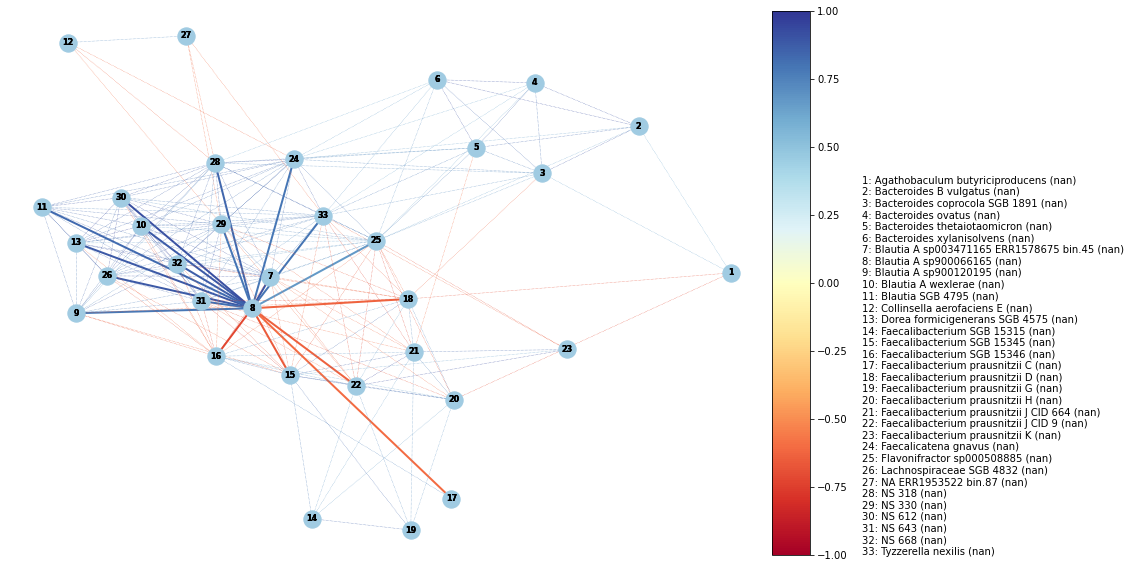

In [5]:
cname1  = "label1"
cname2  = "label2"
coef    = .6
expen   = 2

n, l, sc = make_graph(df, target, cname1, cname2, coef, expen, 16, cmap='RdYlBu')

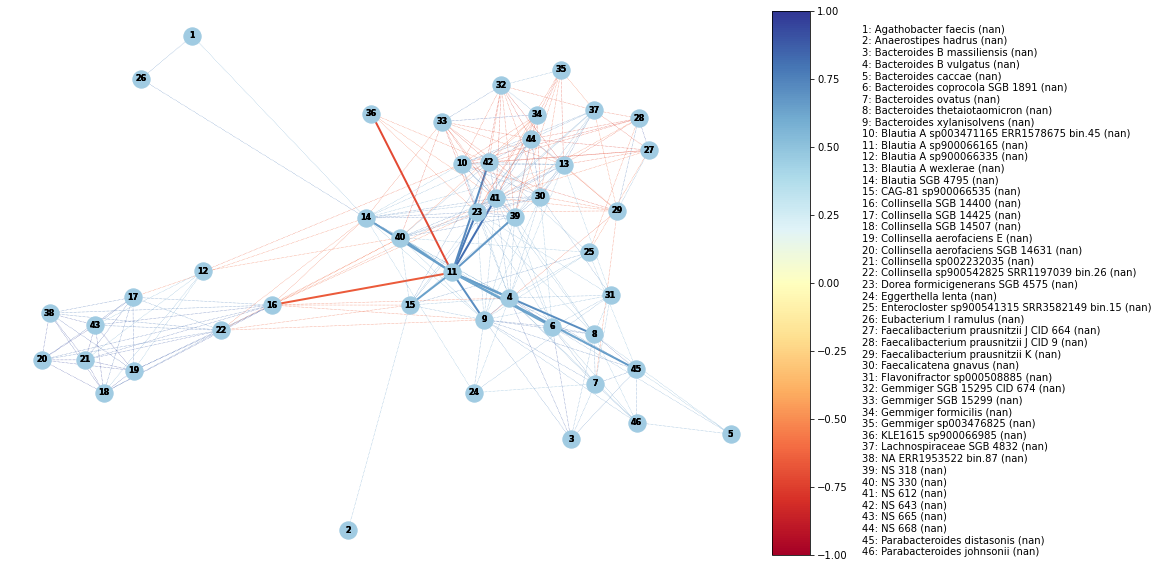

In [6]:
fname = "../tables/bgc_bact_no_trans_corr_edge_bins.tsv"
df = pd.read_csv(fname, sep="\t")
df = add_labels(df, genus_mapper)

n, l, sc = make_graph(df, target, cname1, cname2, coef, expen, 16, cmap='RdYlBu')